# Set up

In [1]:
# Analyze the biochemical features of the target products and subsets thereof
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

sns.set(style='whitegrid',
    font='Arial', font_scale=1,
    rc={'figure.figsize':(4,4)})
sns.set_palette('pastel')

plt.rcParams["figure.figsize"] = (4,4)

%matplotlib inline

In [2]:
# Parse molecule string to dictionary of element:number
# Convert formulas to dict, note that CH.., C1H.., and C2H.. are all possible and elements might apper in any order.
def get_molecule(element_string):
    #print(element_string)
    molecule = {}
    for element_and_number in  re.findall("[A-Z][a-z]*[0-9]*", element_string):
        match = re.search("([A-Z][a-z]*)([0-9]*)", element_and_number)
        element = match.group(1)
        number = match.group(2)
        if number == '':
            number = 1
        molecule[element] = float(number)  # This should be an int, but some models might violate that for pseudo-metabolites
    return molecule

valency = {'C':4, 'H':1, 'O':-2, 'N':-3, 'P':5,'S':-2, 'Mo':6, 'Fe':2, 'Cu':2} # IMPORTANT NOTE: This depends on how many electrons are being donated in a certain molecule
def get_dor(molecule):
    numerator = 0
    for element,number in molecule.items():
        numerator = numerator + valency[element]*number
    return numerator/molecule['C']  # electrons (donated to reach full valence shell)/carbon atom

# Test the functions above with different strings for ethanol
assert(get_dor(get_molecule('C2H6O')) == 6)
assert(get_dor(get_molecule('OC2H6')) == 6)
assert(get_dor(get_molecule('C2H6O1')) == 6)

#weights = {'C':12.011, 'H':1.008"}
#def get_mw(molecule):
    

In [3]:
# Molecular weight
import cobra as cb
model = cb.io.load_json_model('../../cases/ecoli-native-matlab/input/parent-model-generation/iML1515.json')
def get_mw(metabolite_id_nc):
    if f'{metabolite_id_nc}_c' in model.metabolites:  
        met = model.metabolites.get_by_id(f'{metabolite_id_nc}_c')
    elif f'{metabolite_id_nc}_p' in model.metabolites:  
        met = model.metabolites.get_by_id(f'{metabolite_id_nc}_p')
    else:
        raise(ValueError(metabolite_id_nc))
    return met.formula_weight

# All products

In [4]:
df = pd.read_csv('../../cases/ecoli-native-matlab/input/metabolite_table.csv')
#df = pd.read_csv('../../cases/ecoli-native-aerobic-matlab/input/metabolite_table.csv')

df['c_atoms'] = df['formula'].map(lambda x: get_molecule(x)['C'])
df['h_atoms'] = df['formula'].map(lambda x: get_molecule(x).get('',0))
df['o_atoms'] = df['formula'].map(lambda x: get_molecule(x).get('O',0))
df['p_atoms'] = df['formula'].map(lambda x: get_molecule(x).get('P',0))
df['dor'] = df['formula'].map(lambda x: get_dor(get_molecule(x)))
df['mw'] = df['id'].map(lambda x: get_mw(x))
df.head()

,id,name,formula,charge,kegg_id,bigg_id,notes,c_atoms,h_atoms,o_atoms,p_atoms,dor,mw
0,12dgr120,"1,2-Diacyl-sn-glycerol (didodecanoyl, n-C12:0)",C27H52O5,0,NaN,NaN,NaN,27.0,0,5.0,0.0,5.555556,456.69878
1,12dgr140,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,0,NaN,NaN,NaN,31.0,0,5.0,0.0,5.612903,512.80510
2,12dgr141,"1,2-Diacyl-sn-glycerol (ditetradec-7-enoyl, n-...",C31H56O5,0,NaN,NaN,NaN,31.0,0,5.0,0.0,5.483871,508.77334
3,12dgr160,"1,2-Diacyl-sn-glycerol (dihexadecanoyl, n-C16:0)",C35H68O5,0,NaN,NaN,NaN,35.0,0,5.0,0.0,5.657143,568.91142
4,12dgr161,"1,2-Diacyl-sn-glycerol (dihexadec-9-enoyl, n-C...",C35H64O5,0,NaN,NaN,NaN,35.0,0,5.0,0.0,5.542857,564.87966


In [5]:
# TODO: Remove  duplicate code
def plot_hist_discrete(data, ax, xlabel, ylabel, rwidth=.5):
    
    bins = np.arange(0, data.max() + 1.5) - 0.5  # Centered bins for discrete values

    ax.hist(data, bins=bins, rwidth=rwidth,  
             weights=np.ones(len(data)) / len(data))  # Format y axis as %
    
    xticks = bins + 0.5  # Centered bins for discrete values
    n_xticks = 10  # upper bound to the number of xticks
    xticks = xticks[np.round(np.linspace(0, len(xticks) - 1, n_xticks)).astype(int)]
    ax.set_xticks(xticks)  
    
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))  # Format y axis as %
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
def plot_hist(data, ax, xlabel, ylabel,bins):
    
    ax.hist(data, bins=bins,
            weights=np.ones(len(data)) / len(data))  # Format y axis as %
    
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))  # Format y axis as %
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    ax.xaxis.grid(False)
    ax.grid(which='major', axis='y', linestyle='--')

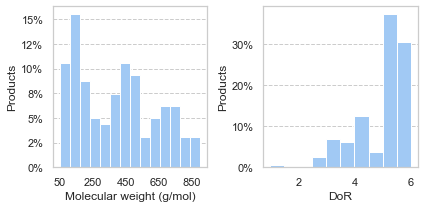

In [6]:
data = df['p_atoms']
ylabel = "Products"
xlabel = "P atoms"

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3*2,3))

#plot_hist_discrete(data=df['p_atoms'], ax=ax, xlabel="Products", ylabel="P atoms")
plot_hist(data=df['mw'], ax=ax[0], xlabel="Molecular weight (g/mol)", ylabel="Products",bins=np.linspace(50, 900, 15))
#ax[0].set_xlim(50,900)
ax[0].set_xticks(np.arange(50, 900, 200))

#plot_hist(data=df['dor'], ax=ax[1], xlabel="DoR", ylabel="Products",bins=np.linspace(1, 7, 10))
plot_hist(data=df['dor'], ax=ax[1], xlabel="DoR", ylabel="Products",bins=None)

#ax[1].set_xticks([2,3,4,5,6])

#ax[0].text(-0.3, 1.05,  'B', transform=ax.transAxes, size=20)
#ax[0].text(-.3,.2,  'b', size=20)

plt.tight_layout()
plt.savefig("biochemical-native-bc.svgz")

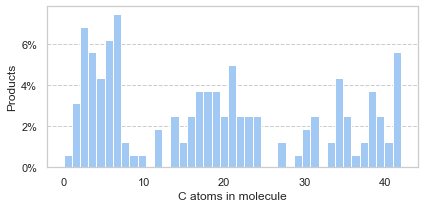

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*2,3))

data=df['c_atoms']
weights=np.ones(len(data)) / len(data)

bins = np.linspace(0, data.max(), data.max())

plt.hist(data, bins, alpha=1, label='C',  weights=weights)
ax = plt.gca()
#plt.hist(df['o_atoms'], bins, alpha=0.6, label='O',   weights=weights)
#plt.hist(df['h_atoms'], bins, alpha=0.5, label='H')
#ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.hist(df['p_atoms'], bins, alpha=0.6, label='P',  weights=weights)

#plt.legend(loc='upper right')

ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))  # Format y axis as %
    
ax.set_ylabel('Products')
ax.set_xlabel('C atoms in molecule')
    
ax.xaxis.grid(False)
ax.grid(which='major', axis='y', linestyle='--')

plt.tight_layout()
plt.savefig("biochemical-native-a.svgz")

# Design objectives compared to biochemical properties

In [8]:
rdf = pd.read_csv('../../analysis/native/results/a5_b1.csv', index_col='Solution index')
rdf.head()

,Deletion_id,12dgr120(module),12dgr140(module),12dgr141(module),12dgr160(module),12dgr161(module),12dgr180(module),12dgr181(module),1agpe120(module),1agpe140(module),...,sbt6p(objective),ser__L(objective),succ(objective),sucsal(objective),tre(objective),ttdca(objective),ttdcap(objective),ttdcea(objective),ttdceap(objective),val__L(objective)
Solution index,,,,,,,,,,,,,,,,,,,,,
1,"ACALD, G3PD2, CBMKr, TPI, I4FE4SR",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.001889,0.0,0.0,0.276488,0.0,0.294501,0.0,0.0
2,"ALCD2x, G3PD2, CBMKr, TPI",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.001889,0.0,0.0,0.276488,0.0,0.294501,0.0,0.0
3,"ACALD, AMPN, ASPO6, TPI",NaN,NaN,NaN,NaN,NaN,TPI,NaN,NaN,NaN,...,0.0,0.0,0.001913,0.0,0.0,0.277209,0.0,0.532836,0.0,0.0
4,"ACALD, TPI, ALR4x, 6D6SPA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.001913,0.0,0.0,0.277209,0.0,0.295234,0.0,0.0
5,"ACALD, LYSAM, TPI",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.001913,0.0,0.0,0.277209,0.0,0.295234,0.0,0.0


In [9]:
#rdf.filter(like='(objective)').columns
obj_cols = [col for col in rdf.columns if '(objective)' in col]
ordf = rdf[obj_cols]
ordf.columns = ordf.columns.str.replace('\(objective\)', '')
ordf.head()

,12dgr120,12dgr140,12dgr141,12dgr160,12dgr161,12dgr180,12dgr181,1agpe120,1agpe140,1agpe160,...,sbt6p,ser__L,succ,sucsal,tre,ttdca,ttdcap,ttdcea,ttdceap,val__L
Solution index,,,,,,,,,,,,,,,,,,,,,
1,0.0,-0.0,0.0,0.0,0.0,0.000000,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.001889,0.0,0.0,0.276488,0.0,0.294501,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.001889,0.0,0.0,0.276488,0.0,0.294501,0.0,0.0
3,-0.0,0.0,0.0,0.0,0.0,0.496509,0.0,0.0,0.0,0.0,...,0.0,0.0,0.001913,0.0,0.0,0.277209,0.0,0.532836,0.0,0.0
4,-0.0,0.0,0.0,0.0,0.0,0.289311,0.0,0.0,0.0,0.0,...,0.0,0.0,0.001913,0.0,0.0,0.277209,0.0,0.295234,0.0,0.0
5,-0.0,0.0,0.0,0.0,0.0,0.289311,0.0,0.0,0.0,0.0,...,0.0,0.0,0.001913,0.0,0.0,0.277209,0.0,0.295234,0.0,0.0


In [10]:
s = ordf.max(0).to_dict()
df['max_obj'] = df['id'].map(lambda x: s[x])

s = ordf.mean(0).to_dict()
df['mean_obj'] = df['id'].map(lambda x: s[x])

vdf = df[['id','c_atoms','mw','dor','max_obj','mean_obj']]


In [11]:
# Drop below value (either not compatible or 0)
compatibility_t = .5
tbl = vdf[vdf['max_obj'] >= compatibility_t]
#tbl=vdf

pc = tbl.corr()
pc

,c_atoms,mw,dor,max_obj,mean_obj
c_atoms,1.000000,0.979769,0.454726,-0.178319,-0.375175
mw,0.979769,1.000000,0.422393,-0.243390,-0.452404
dor,0.454726,0.422393,1.000000,0.243815,0.005564
max_obj,-0.178319,-0.243390,0.243815,1.000000,0.368462
mean_obj,-0.375175,-0.452404,0.005564,0.368462,1.000000


In [12]:
sns.set_style("white")

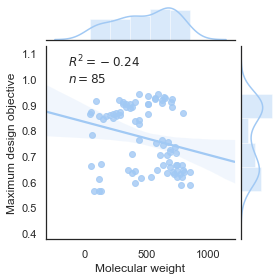

In [13]:
xid = 'mw'
yid = 'max_obj'
g = sns.jointplot(xid,yid,tbl, kind="reg", height=4)

g.fig.text(0.25,0.7, '$R^2={:.2f}$\n$n={}$'.format(pc.loc[xid,yid],tbl.shape[0]), ha='left', fontsize = 12);
g.set_axis_labels("Molecular weight", "Maximum design objective")
#plt.set_xlims(0.5,1)
plt.savefig('correlation_1.svg')

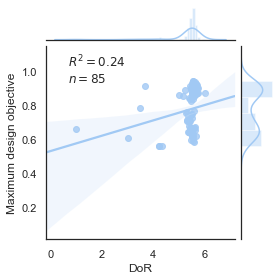

In [14]:
xid = 'dor'
yid = 'max_obj'
g = sns.jointplot(xid,yid,tbl, kind="reg", height=4)

g.fig.text(0.25,0.7, '$R^2={:.2f}$\n$n={}$'.format(pc.loc[xid,yid],tbl.shape[0]), ha='left', fontsize = 12);
g.set_axis_labels("DoR", "Maximum design objective")
plt.savefig('correlation_2.svg')

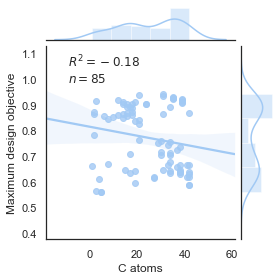

In [15]:
xid = 'c_atoms'
yid = 'max_obj'
g = sns.jointplot(xid,yid,tbl, kind="reg", height=4)

g.fig.text(0.25,0.7, '$R^2={:.2f}$\n$n={}$'.format(pc.loc[xid,yid],tbl.shape[0]), ha='left', fontsize = 12);
g.set_axis_labels("C atoms", "Maximum design objective")
plt.savefig('correlation_3.svg')

# Other

In [16]:
df.sort_values(by=['dor'])

,id,name,formula,charge,kegg_id,bigg_id,notes,c_atoms,h_atoms,o_atoms,p_atoms,dor,mw,max_obj,mean_obj
84,for,Formate,CH1O2,-1,NaN,NaN,NaN,1.0,0,2.0,0.0,1.000000,45.017440,0.662726,0.227866
102,mal__L,L-Malate,C4H4O5,-2,NaN,NaN,NaN,4.0,0,5.0,0.0,2.500000,132.071560,0.000000,0.000000
85,fum,Fumarate,C4H2O4,-2,NaN,NaN,NaN,4.0,0,4.0,0.0,2.500000,114.056280,0.000000,0.000000
42,2amsa,2-Aminomalonate semialdehyde,C3H5NO3,0,NaN,NaN,NaN,3.0,0,3.0,0.0,2.666667,103.076700,0.000000,0.000000
68,akg,2-Oxoglutarate,C5H4O5,-2,NaN,NaN,NaN,5.0,0,5.0,0.0,2.800000,144.082260,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,hdcap,Hexadecanoyl-phosphate (n-C16:0),C16H32O5P,-1,NaN,NaN,NaN,16.0,0,5.0,1.0,5.687500,335.396041,0.903169,0.358883
5,12dgr180,"1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)",C39H76O5,0,NaN,NaN,NaN,39.0,0,5.0,0.0,5.692308,625.017740,0.919785,0.326973
106,ocdca,Octadecanoate (n-C18:0),C18H35O2,-1,NaN,NaN,NaN,18.0,0,2.0,0.0,5.722222,283.469300,0.872001,0.360470
107,ocdcap,Octadecanoyl-phosphate (n-C18:0),C18H36O5P,-1,NaN,NaN,NaN,18.0,0,5.0,1.0,5.722222,363.449201,0.901917,0.358428


# Design-specific

In [18]:
# TODO:
# For the histograms, overlap the overall product properties with the products on specific designs
# see: https://seaborn.pydata.org/examples/distplot_options.html

In [19]:
import pickle

with open ('products.pickle', 'rb') as fp:
    itemlist = pickle.load(fp)
hexoses = itemlist[0]
pentoses = itemlist[1]


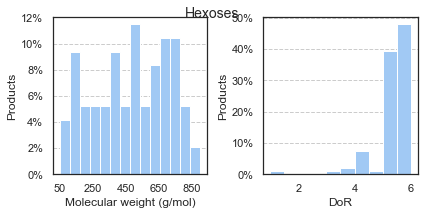

In [20]:
tdf = df.set_index('id')
tdf = tdf.loc[hexoses]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3*2,3))

plot_hist(data=tdf['mw'], ax=ax[0], xlabel="Molecular weight (g/mol)", ylabel="Products",bins=np.linspace(50, 900, 15))
ax[0].set_xticks(np.arange(50, 900, 200))

plot_hist(data=tdf['dor'], ax=ax[1], xlabel="DoR", ylabel="Products",bins=None)

plt.suptitle('Hexoses', fontsize=14)

plt.tight_layout()
#plt.savefig("biochemical-native-bc.svgz")

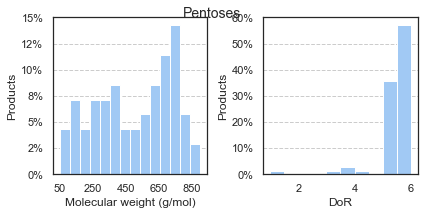

In [21]:
tdf = df.set_index('id')
tdf = tdf.loc[pentoses]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3*2,3))

plot_hist(data=tdf['mw'], ax=ax[0], xlabel="Molecular weight (g/mol)", ylabel="Products",bins=np.linspace(50, 900, 15))
ax[0].set_xticks(np.arange(50, 900, 200))

plot_hist(data=tdf['dor'], ax=ax[1], xlabel="DoR", ylabel="Products",bins=None)

plt.suptitle('Pentoses', fontsize=14)

plt.tight_layout()

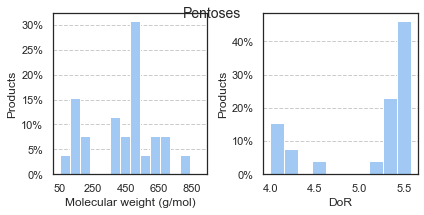

In [22]:
only_hexoses=hexoses.difference(pentoses)

tdf = df.set_index('id')
tdf = tdf.loc[only_hexoses]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3*2,3))

plot_hist(data=tdf['mw'], ax=ax[0], xlabel="Molecular weight (g/mol)", ylabel="Products",bins=np.linspace(50, 900, 15))
ax[0].set_xticks(np.arange(50, 900, 200))

plot_hist(data=tdf['dor'], ax=ax[1], xlabel="DoR", ylabel="Products",bins=None)

plt.suptitle('Pentoses', fontsize=14)

plt.tight_layout()

In [24]:
sns.set(style='whitegrid',
    font='Arial', font_scale=1,
    rc={'figure.figsize':(4,4)})
sns.set_palette('pastel')

plt.rcParams["figure.figsize"] = (4,4)

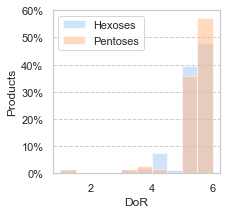

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))

tdf = df.set_index('id')
tdf = tdf.loc[hexoses]
data=tdf['dor']


bins=np.linspace(50, 900, 15)

ax.hist(data,alpha=0.5,
            weights=np.ones(len(data)) / len(data),  label='Hexoses')  # Format y axis as %
   
    
tdf = df.set_index('id')
tdf = tdf.loc[pentoses]
data=tdf['dor']

ax.hist(data, alpha=0.5,
            weights=np.ones(len(data)) / len(data), label='Pentoses')  # Format y axis as %
    
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))  # Format y axis as %
    
ax.set_ylabel(ylabel)
ax.set_xlabel('DoR')
    
ax.xaxis.grid(False)
ax.grid(which='major', axis='y', linestyle='--')

ax.legend()

plt.savefig('../overall-sugars/dor.svgz')